Stopping search: maximum iterations reached --> 30

✅ Best parameters found by PSO:
   k = 47
   weights = 'distance'
   p = 2
   metric = 'manhattan'
   leaf_size = 10
🎯 Final test accuracy: 0.8339


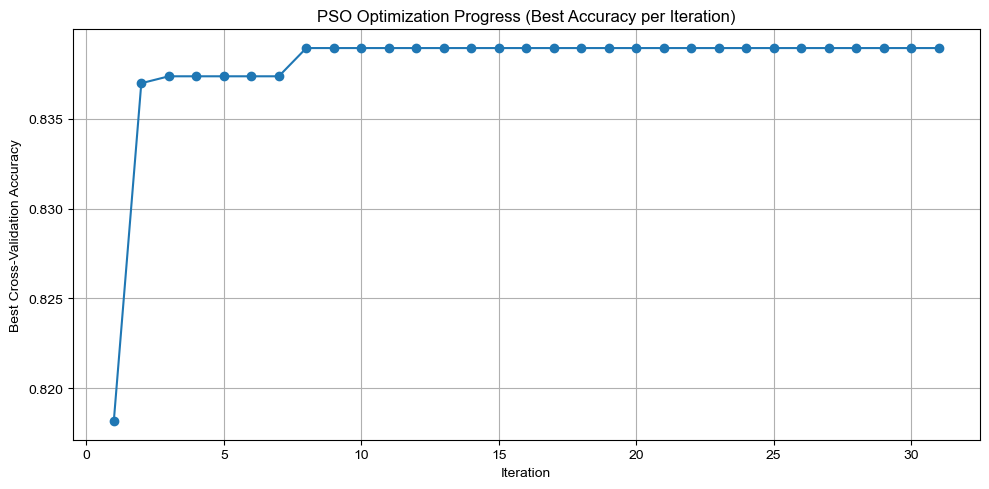

In [21]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from pyswarm import pso
import matplotlib.pyplot as plt

# Step 1: Load and preprocess data
dataset = fetch_ucirepo(id=69)
X_raw = dataset.data.features
y_raw = dataset.data.targets

X = OrdinalEncoder().fit_transform(X_raw)
y = LabelEncoder().fit_transform(y_raw.values.ravel())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Setup for PSO
weights_options = ['uniform', 'distance']
metric_options = ['minkowski', 'manhattan', 'chebyshev']

accuracy_scores = []
best_accuracy_per_iter = []

swarmsize = 10
maxiter = 30

# Step 3: Define PSO objective function
def knn_objective(params):
    try:
        k = int(round(params[0]))
        weight_idx = int(round(params[1]))
        p = int(round(params[2]))
        metric_idx = int(round(params[3]))
        leaf_size = int(round(params[4]))

        if (k < 1 or k > 50 or weight_idx not in [0, 1] or
            p < 1 or p > 10 or metric_idx not in [0, 1, 2] or
            leaf_size < 10 or leaf_size > 100):
            return 1.0

        model = KNeighborsClassifier(
            n_neighbors=k,
            weights=weights_options[weight_idx],
            p=p,
            metric=metric_options[metric_idx],
            leaf_size=leaf_size
        )

        score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        mean_score = score.mean()

        accuracy_scores.append(mean_score)
        if len(accuracy_scores) % swarmsize == 0:
            best_this_iter = max(accuracy_scores[-swarmsize:])
            best_accuracy_per_iter.append(best_this_iter)

        return -mean_score
    except Exception as e:
        print("Error:", e)
        return 1.0

# Step 4: Run PSO with fixed parameters
lb = [1, 0, 1, 0, 10]     # k, weight_idx, p, metric_idx, leaf_size
ub = [50, 1, 10, 2, 100]
np.random.seed(42)
best_params, _ = pso(
    knn_objective,
    lb=lb,
    ub=ub,
    swarmsize=swarmsize,
    maxiter=maxiter,
    omega=0.5,
    phip=1.5,
    phig=1.5
)

# Step 5: Extract best parameters
best_k = int(round(best_params[0]))
best_weight = weights_options[int(round(best_params[1]))]
best_p = int(round(best_params[2]))
best_metric = metric_options[int(round(best_params[3]))]
best_leaf = int(round(best_params[4]))

# Step 6: Evaluate on test set
final_model = KNeighborsClassifier(
    n_neighbors=best_k,
    weights=best_weight,
    p=best_p,
    metric=best_metric,
    leaf_size=best_leaf
)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)

print("\n✅ Best parameters found by PSO:")
print(f"   k = {best_k}")
print(f"   weights = '{best_weight}'")
print(f"   p = {best_p}")
print(f"   metric = '{best_metric}'")
print(f"   leaf_size = {best_leaf}")
print(f"🎯 Final test accuracy: {final_accuracy:.4f}")

# Step 7: Plot optimization progress
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(best_accuracy_per_iter)+1), best_accuracy_per_iter, marker='o')
plt.title("PSO Optimization Progress (Best Accuracy per Iteration)")
plt.xlabel("Iteration")
plt.ylabel("Best Cross-Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()
